In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import gc, numpy as np, pickle
import tensorflow as tf

#train_text [num of video, max num of utterance = max_utt_len, dim of representation]
#train_len: num of utterance in every video

#(train_text, train_label, test_text, test_label, max_utt_len, train_len, test_len) = pickle.load(open('/content/mytext_revise.pickle', 'rb'))
(train_text, train_label,max_utt_len, train_len, test_len) = pickle.load(open('/content/mytext_auto1.pickle', 'rb'))
(test_text, test_label,train_score, test_score) = pickle.load(open('/content/mytext_auto2.pickle', 'rb'))

#(train_audio, _, test_audio, _, _, _, _) = pickle.load(open('./input/audio.pickle', 'rb'))

#original one
#(train_video, _, test_video, _, _, _, _) = pickle.load(open('/content/video.pickle', 'rb'))
train_video = pickle.load(open('/content/video_train.pickle','rb'))
test_video = pickle.load(open('/content/video_test.pickle','rb'))

In [ ]:
import torch
train_text = torch.tensor(train_text)
train_video = torch.tensor(train_video)
test_text = torch.tensor(test_text)
test_video = torch.tensor(test_video)
train_auto = torch.cat((train_text,train_video),2)
test_auto = torch.cat((test_text,test_video),2)

In [85]:
train_auto = train_auto.to(torch.float32)
test_auto = test_auto.to(torch.float32)

In [5]:
#mask zero value to speed up

def create_mask(train_data, test_data, train_length, test_length, test_label):
    '''
    # Arguments
        train, test data (any one modality (text, audio or video)), utterance lengths in train, test videos
    # Returns
        mask for train and test data
    '''

    train_mask = np.zeros((train_data.shape[0], train_data.shape[1]), dtype='float')
    for i in range(len(train_length)):
        train_mask[i, :train_length[i]] = 1.0

    test_mask = np.zeros((test_data.shape[0], test_data.shape[1]), dtype='float')
    for i in range(len(test_length)):
        test_mask[i, :test_length[i]] = 1.0
    
    #give up neutral cases
    for i in range(test_label.shape[0]):
        for j in range(test_label.shape[1]):
            if test_label[i][j] == -1:
                #print('yes')
                test_mask[i][j] = 0.0

    return train_mask, test_mask

In [6]:
train_mask, test_mask = create_mask(train_auto, test_auto, train_len, test_len, test_label)

In [8]:
train_mask[0]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [38]:
#hyperparameter
import torch.nn as nn
import torch.nn.functional as F

hid_dim = 50
input_dim = 135

# Creating a PyTorch class
# 135 ==> hid_dim ==> 135

class MaskedLinear(nn.Linear):
    """ same as Linear except has a configurable mask on the weights """
    
    def __init__(self, in_features, out_features, bias=True):
        super().__init__(in_features, out_features, bias)        
        self.register_buffer('mask', torch.ones(out_features, in_features))
        
    def set_mask(self, mask):
        self.mask.data.copy_(torch.from_numpy(mask.astype(np.uint8).T))
        
    def forward(self, input):
        return F.linear(input, self.mask * self.weight, self.bias)


class AE(torch.nn.Module):
	def __init__(self, mask1, mask2):
		super().__init__()
		
		# Building an linear encoder with Linear
		# layer followed by Relu activation function
		if self.training:
				self.mask = mask1
		else:
				self.mask = mask2
		self.encoder = torch.nn.Sequential(
      MaskedLinear(input_dim, 128),
			#torch.nn.Linear(input_dim, 128),
			torch.nn.LeakyReLU(),
			MaskedLinear(128, 64),
			
      #torch.nn.Linear(128, 64),
			torch.nn.LeakyReLU(),
      MaskedLinear(64, hid_dim)
			#torch.nn.Linear(64, hid_dim)
   
		)
  
		
    
		# Building an linear decoder with Linear
		# layer followed by Relu activation function
		# The Sigmoid activation function

		self.decoder = torch.nn.Sequential(
			MaskedLinear(hid_dim, 64),
			#torch.nn.Linear(hid_dim, 64),
			torch.nn.LeakyReLU(),
      MaskedLinear(64, 128),
			#torch.nn.Linear(64, 128),
			torch.nn.LeakyReLU(),
      MaskedLinear(128, input_dim),
			#torch.nn.Linear(128, input_dim)
		)

	def forward(self, x):
		encoded = self.encoder(x)
		decoded = self.decoder(encoded)
		return decoded



In [86]:
# Model Initialization
model = AE(train_mask, test_mask)

# Validation using MSE Loss function
loss_function = torch.nn.MSELoss()

# Using an Adam Optimizer with lr = 0.1
optimizer = torch.optim.Adam(model.parameters(),
							lr = 1e-1,
							weight_decay = 1e-8)


epoch:191, loss:4.1160
epoch:192, loss:4.0901
epoch:193, loss:4.0646
epoch:194, loss:4.0393
epoch:195, loss:4.0143
epoch:196, loss:3.9896
epoch:197, loss:3.9653
epoch:198, loss:3.9412
epoch:199, loss:3.9174


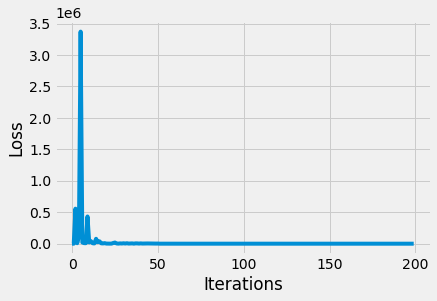

In [25]:
#hiddim = 80
import matplotlib.pyplot as plt
epochs = 200
outputs = []
losses = []
for epoch in range(epochs):
	
	
	# Output of Autoencoder
	reconstructed = model(train_auto)
	
	# Calculating the loss function
	loss = loss_function(reconstructed, train_auto)
	
	# The gradients are set to zero,
	# the gradient is computed and stored.
	# .step() performs parameter update
	optimizer.zero_grad()
	loss.backward()
	optimizer.step()
	
	# Storing the losses in a list for plotting
	losses.append(loss.detach().numpy())
	if epoch > epochs - 10:
		print('epoch:%d, loss:%.4f'%(epoch, loss))

# Defining the Plot Style
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')

# Plotting the last 100 values
plt.plot(losses)


epoch:191, loss:0.4437
epoch:192, loss:0.4435
epoch:193, loss:0.4433
epoch:194, loss:0.4432
epoch:195, loss:0.4430
epoch:196, loss:0.4428
epoch:197, loss:0.4426
epoch:198, loss:0.4424
epoch:199, loss:0.4422


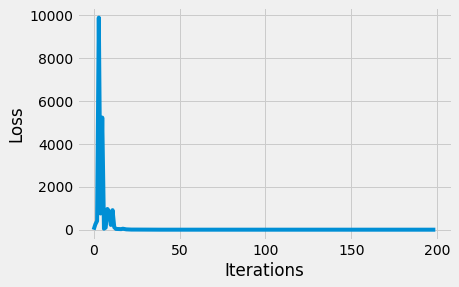

In [33]:
import matplotlib.pyplot as plt
#hid_dim = 20
epochs = 200
outputs = []
losses = []
for epoch in range(epochs):
	
	
	# Output of Autoencoder
	reconstructed = model(train_auto)
	
	# Calculating the loss function
	loss = loss_function(reconstructed, train_auto)
	
	# The gradients are set to zero,
	# the gradient is computed and stored.
	# .step() performs parameter update
	optimizer.zero_grad()
	loss.backward()
	optimizer.step()
	
	# Storing the losses in a list for plotting
	losses.append(loss.detach().numpy())
	if epoch > epochs - 10:
		print('epoch:%d, loss:%.4f'%(epoch, loss))


# Defining the Plot Style
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')

# Plotting the last 100 values
plt.plot(losses)


epoch:191, loss:0.4519
epoch:192, loss:0.4513
epoch:193, loss:0.4507
epoch:194, loss:0.4501
epoch:195, loss:0.4495
epoch:196, loss:0.4489
epoch:197, loss:0.4483
epoch:198, loss:0.4477
epoch:199, loss:0.4472


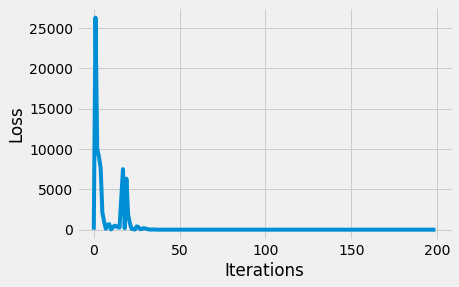

In [87]:
#hiddim = 50
import matplotlib.pyplot as plt
epochs = 200
outputs = []
losses = []
for epoch in range(epochs):
	
	
	# Output of Autoencoder
	reconstructed = model(train_auto)
	
	# Calculating the loss function
	loss = loss_function(reconstructed, train_auto)
	
	# The gradients are set to zero,
	# the gradient is computed and stored.
	# .step() performs parameter update
	optimizer.zero_grad()
	loss.backward()
	optimizer.step()
	
	# Storing the losses in a list for plotting
	losses.append(loss.detach().numpy())
	if epoch > epochs - 10:
		print('epoch:%d, loss:%.4f'%(epoch, loss))


# Defining the Plot Style
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')

# Plotting the last 100 values
plt.plot(losses)


In [88]:
model.train()
print(model.training)
train_features = model.encoder(train_auto)
model.eval()
print(model.training)
test_features = model.encoder(test_auto)
torch.save(model.state_dict(), './aemodel_50.pt')

True
False


In [83]:
train_features[0] == train_features[1]

tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [ True,  True,  True,  ...,  True,  True,  True],
        [ True,  True,  True,  ...,  True,  True,  True],
        [ True,  True,  True,  ...,  True,  True,  True]])

In [89]:
model.train()
train_de = model.decoder(train_features)
model.training

True

In [90]:
train_de[0]

tensor([[-0.1409,  0.4170,  0.7610,  ..., -0.6004, -1.5470,  0.2494],
        [-0.0993,  0.3440,  0.6549,  ..., -0.5001, -1.4406,  0.2813],
        [-0.0942,  0.3655,  0.6739,  ..., -0.5191, -1.4601,  0.3086],
        ...,
        [ 0.2943, -0.0820, -0.1167,  ...,  0.1489, -0.6465,  0.1339],
        [ 0.2943, -0.0820, -0.1167,  ...,  0.1489, -0.6465,  0.1339],
        [ 0.2943, -0.0820, -0.1167,  ...,  0.1489, -0.6465,  0.1339]],
       grad_fn=<SelectBackward0>)

In [46]:
train_auto[0]

tensor([[-0.1787,  0.0194,  0.2821,  ..., -4.1088,  0.5166,  2.6611],
        [ 0.0953,  0.1078,  0.2935,  ..., -3.8363,  4.8980,  3.4719],
        [-0.0816,  0.1248,  0.4574,  ..., -4.8289,  1.7792,  3.6170],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])

In [91]:
model.eval()
test_de = model.decoder(test_features)

In [92]:
test_de[0]

tensor([[-0.1477,  0.2910,  0.6319,  ..., -0.4755, -1.4147,  0.1176],
        [-0.1306,  0.3863,  0.7193,  ..., -0.5630, -1.5041,  0.2218],
        [-0.1805,  0.4118,  0.7819,  ..., -0.6196, -1.5660,  0.1401],
        ...,
        [ 0.2943, -0.0820, -0.1167,  ...,  0.1489, -0.6465,  0.1339],
        [ 0.2943, -0.0820, -0.1167,  ...,  0.1489, -0.6465,  0.1339],
        [ 0.2943, -0.0820, -0.1167,  ...,  0.1489, -0.6465,  0.1339]],
       grad_fn=<SelectBackward0>)

In [93]:
test_auto[0]

tensor([[ -0.1952,   0.2739,   0.4649,  ..., -11.9612, -10.5791,   3.6253],
        [  0.0756,   0.0618,   0.6579,  ...,  -5.9105, -11.3419,   5.1939],
        [ -0.1144,   0.2752,   0.4820,  ...,  -8.6218, -11.7895,   4.2655],
        ...,
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000]])

In [176]:
class Conv(nn.Module):
    def __init__(self, num_classes=1):
        super(Conv, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv1d(1, 4, kernel_size=3, stride=1, padding=0),
            #nn.BatchNorm2d(16),
            nn.ReLU())
            #nn.MaxPool2d(kernel_size=2, stride=2))#2*2 pooling
        self.layer2 = nn.Sequential(
            nn.Conv1d(4, 8, kernel_size=3, stride=1, padding=0),
            #nn.BatchNorm2d(32),
            nn.ReLU())
            #nn.MaxPool2d(kernel_size=2, stride=2))#2*2 pooling
        self.fc = nn.Linear(47*8, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        #print(out.shape)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

model_cov = Conv()

# Loss and optimizer
criterion = torch.nn.MSELoss(reduction='none')
optimizer = torch.optim.Adam(model_cov.parameters(), lr=0.001)

In [94]:
train_score = torch.tensor(train_score)
test_score = torch.tensor(test_score)

train_score = train_score.to(torch.float32)
test_score = test_score.to(torch.float32)

train_features = torch.cat((train_score,train_features), 2)
test_features = torch.cat((test_score,test_features), 2)

<ipython-input-94-667d4b9d748e>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_score = torch.tensor(train_score)
<ipython-input-94-667d4b9d748e>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_score = torch.tensor(test_score)


In [96]:
test_features.shape

torch.Size([31, 63, 51])

In [97]:
train_features = train_features.reshape(61*63,1, 51)
test_features = test_features.reshape(31*63,1, 51)

In [98]:
train_label = torch.tensor(train_label).reshape(61*63,1)
test_label = torch.tensor(test_label).reshape(31*63,1)

<ipython-input-98-a1845001d3c6>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_label = torch.tensor(train_label).reshape(61*63,1)


In [148]:
train_label = train_label.to(torch.float32)
test_label = test_label.to(torch.float32)

In [155]:
loss.dtype

torch.float64

epoch:491, loss:3514.5339
epoch:492, loss:3514.4900
epoch:493, loss:3514.4508
epoch:494, loss:3514.4078
epoch:495, loss:3514.3654
epoch:496, loss:3514.3087
epoch:497, loss:3514.2890
epoch:498, loss:3514.2414
epoch:499, loss:3514.2022


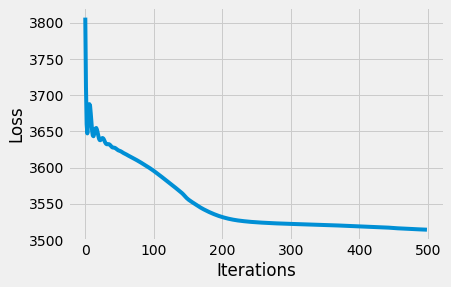

In [177]:

epochs = 500
outputs = []
losses = []
model_cov.train()
for epoch in range(epochs):
	
	optimizer.zero_grad()
	# Output of Autoencoder
	outputs = model_cov(train_features.detach())
	
	# Calculating the loss function
  #masked loss

	loss = criterion(outputs, train_label)
 
	mse = (loss * torch.tensor(train_mask.reshape(61*63, 1))).sum() 
	mse_loss_val = mse / mse.numel()
	#mse_loss_val = mse_loss_val.to(torch.float32)

	# now doing backpropagation
	mse_loss_val.backward()
	#loss = loss_function(reconstructed, train_auto)
	
	# The gradients are set to zero,
	# the gradient is computed and stored.
	# .step() performs parameter update
	
	
	optimizer.step()
	
	# Storing the losses in a list for plotting
	losses.append(mse_loss_val.detach().numpy())
	if epoch > epochs - 10:
		print('epoch:%d, loss:%.4f'%(epoch, mse_loss_val))


# Defining the Plot Style
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')

# Plotting the last 100 values
plt.plot(losses)


In [188]:
model_cov.eval()

res = model_cov(test_features)

In [197]:
sign = test_mask.reshape(31*63, 1)
x = []
y = []
for i in range(31*63):
  if sign[i] == 1:
    x.append(res[i].detach().numpy())
    y.append(test_label[i].detach().numpy())

In [206]:
x = np.array(x).squeeze(1)
y = np.array(y).squeeze(1)

In [209]:
xx = torch.tensor(x)
yy = torch.tensor(y)

In [212]:
test_loss = nn.MSELoss()
test_loss(xx,yy)

tensor(2.3998)

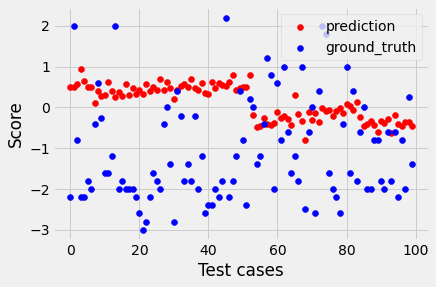

In [226]:
plt.style.use('fivethirtyeight')
plt.xlabel('Test cases')
plt.ylabel('Score')

xaixss = [i for i in range(xx.shape[0])]
plt.scatter(xaixss[:100], xx[:100], color = 'red', label = 'prediction')
plt.scatter(xaixss[:100], yy[:100], color = 'blue', label = 'ground_truth')

plt.legend()
plt.savefig('score.jpg', bbox_inches = 'tight')

In [221]:
count = 0
for i in range(xx.shape[0]):
  if abs(xx[i]-yy[i]) < 1:
    count += 1

print(count/xx.shape[0])

0.3696883852691218


In [225]:
count = 0
for i in range(xx.shape[0]):
  if xx[i] * yy[i] > 0 or (xx[i] <0.1 and yy[i] == 0):
    count += 1

print(count/xx.shape[0])

0.5382436260623229


In [227]:
torch.save(model_cov.state_dict(), './model_conv.pt')